In [1]:
import numpy as np
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

In [2]:
def _convert_image_to_rgb(image):
    return image.convert("RGB")

def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
    ])
    
preprocess = _transform(224)

In [3]:
import bpu_infer_lib

inf = bpu_infer_lib.Infer(False)
inf.load_model("img_encoder.bin")

pic = "dog.jpg"
ima = Image.open(pic)
image = preprocess(ima).unsqueeze(0).to("cpu")
image_np = image.numpy().astype(np.float32)

ret = inf.read_numpy_arr_float32(image_np, 0)
inf.forward()
output = inf.get_infer_res_np_float32(0, 512)
print("img output shape:", output.shape)

The model path is valid and points to a regular file.
[BPU_PLAT]BPU Platform Version(1.3.6)!
[HBRT] set log level as 0. version = 3.15.49.0
[DNN] Runtime version = 1.23.8_(3.15.49 HBRT)
[A][DNN][packed_model.cpp:247][Model](2000-01-01,08:12:36.151.420) [HorizonRT] The model builder version = 1.23.5
[W][DNN]bpu_model_info.cpp:491][Version](2000-01-01,08:12:36.911.543) Model: full_model_11. Inconsistency between the hbrt library version 3.15.49.0 and the model build version 3.15.47.0 detected, in order to ensure correct model results, it is recommended to use compilation tools and the BPU SDK from the same OpenExplorer package.
img output shape: (512,)


In [4]:
"""
text encoding
"""
import onnxruntime as rt
import torch
from typing import Any, Union, List
from pkg_resources import packaging
from simple_tokenizer import SimpleTokenizer as _Tokenizer

_tokenizer = _Tokenizer()

def tokenize(texts: Union[str, List[str]], context_length: int = 77, truncate: bool = False) -> Union[torch.IntTensor, torch.LongTensor]:
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    if packaging.version.parse(torch.__version__) < packaging.version.parse("1.8.0"):
        result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)
    else:
        result = torch.zeros(len(all_tokens), context_length, dtype=torch.int)

    for i, tokens in enumerate(all_tokens):
        if len(tokens) > context_length:
            if truncate:
                tokens = tokens[:context_length]
                tokens[-1] = eot_token
            else:
                raise RuntimeError(f"Input {texts[i]} is too long for context length {context_length}")
        result[i, :len(tokens)] = torch.tensor(tokens)

    return result

device = "cpu"

text = tokenize(["a diagram"]).to(device)
sess = rt.InferenceSession("text_encoder.onnx")
text_np = text.numpy().astype(np.int32)
input_name_0 = sess.get_inputs()[0].name
output_name_0 = sess.get_outputs()[0].name
text_features_diagram = sess.run([output_name_0],{input_name_0:text_np})[0]
print(text_features_diagram.shape)

text = tokenize(["a dog"]).to(device)
sess = rt.InferenceSession("text_encoder.onnx")
text_np = text.numpy().astype(np.int32)
input_name_0 = sess.get_inputs()[0].name
output_name_0 = sess.get_outputs()[0].name
text_features_dog = sess.run([output_name_0],{input_name_0:text_np})[0]
print(text_features_dog.shape)

(1, 512)
(1, 512)


In [5]:
"""
calculate cosine similarity
"""

# Flatten array2 to shape (512,)
text_features_diagram = text_features_diagram.flatten()

# Compute the dot product of the two arrays
dot_product = np.dot(output, text_features_diagram)

# Compute the norms of the two arrays
norm1 = np.linalg.norm(output)
norm2 = np.linalg.norm(text_features_diagram)

# Compute the cosine similarity
cosine_similarity_diagram = dot_product / (norm1 * norm2)

print("Image Cosine Similarity with a diagram:", cosine_similarity_diagram)

# Flatten array2 to shape (512,)
text_features_dog = text_features_dog.flatten()

# Compute the dot product of the two arrays
dot_product = np.dot(output, text_features_dog)

# Compute the norms of the two arrays
norm1 = np.linalg.norm(output)
norm2 = np.linalg.norm(text_features_dog)

# Compute the cosine similarity
cosine_similarity_dog = dot_product / (norm1 * norm2)

print("Image Cosine Similarity with a dog:", cosine_similarity_dog)


Image Cosine Similarity with a diagram: 0.19249962
Image Cosine Similarity with a dog: 0.24834536


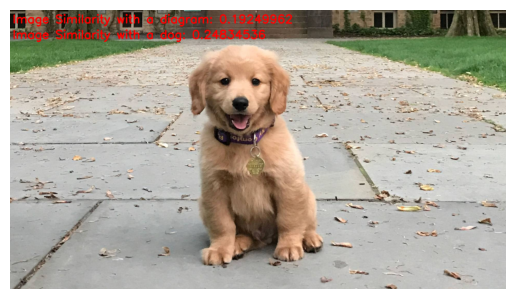

In [6]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('dog.jpg')

# Define the text to write
text1 = "Image Similarity with a diagram: " + str(cosine_similarity_diagram)
text2 = "Image Similarity with a dog: " + str(cosine_similarity_dog)

# Define the bottom-left corner of the text string in the image
org = (10, 50)  # X and Y coordinates
org2 = (10, 110)  # X and Y coordinates

# Define the font, scale, color, and thickness of the text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.5
color = (0, 0, 255)  # White color in BGR
thickness = 3

# Write the text on the image
cv2.putText(image, text1, org, font, font_scale, color, thickness, cv2.LINE_AA)
cv2.putText(image, text2, org2, font, font_scale, color, thickness, cv2.LINE_AA)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()